# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.

This is the main example notebook. It shows learning to hedge a vanilla call option (ATM by default), first in a Black & Scholes world with statistical drift, and secondly in a world where a second option can be traded.
The examples are not intended to be overly realistic.

In the Black & Scholes case we see that the hedge learned is _not_ the risk-neutral hedge. The notebook <tt>trainer-bs_nodrift.ipynb</tt> demonstrates that if the statistical drift is zero, and step size is sufficiently small (daily), then the Deep Hedging hedge approximates the risk-neutral hedge.

### Hans Buehler, June 30 2022


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.11" "tensorflow_probability==0.19"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
my_path = None
if i!=-1:
    my_path = p[:i]
    import sys
    sys.path.append(my_path)
    print("SageMaker: added python path %s" % my_path)
else:
    print(sys.path)

SageMaker: added python path /Users/lisafaloughi/Desktop/DeepHedging


Deep Hedging AI says hello ... 

## Deep Hedging in a Black \& Scholes World

Initializing training at 2025-04-06 00:37:20: gym with 944 trainable weights compiled. Took 0s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/6

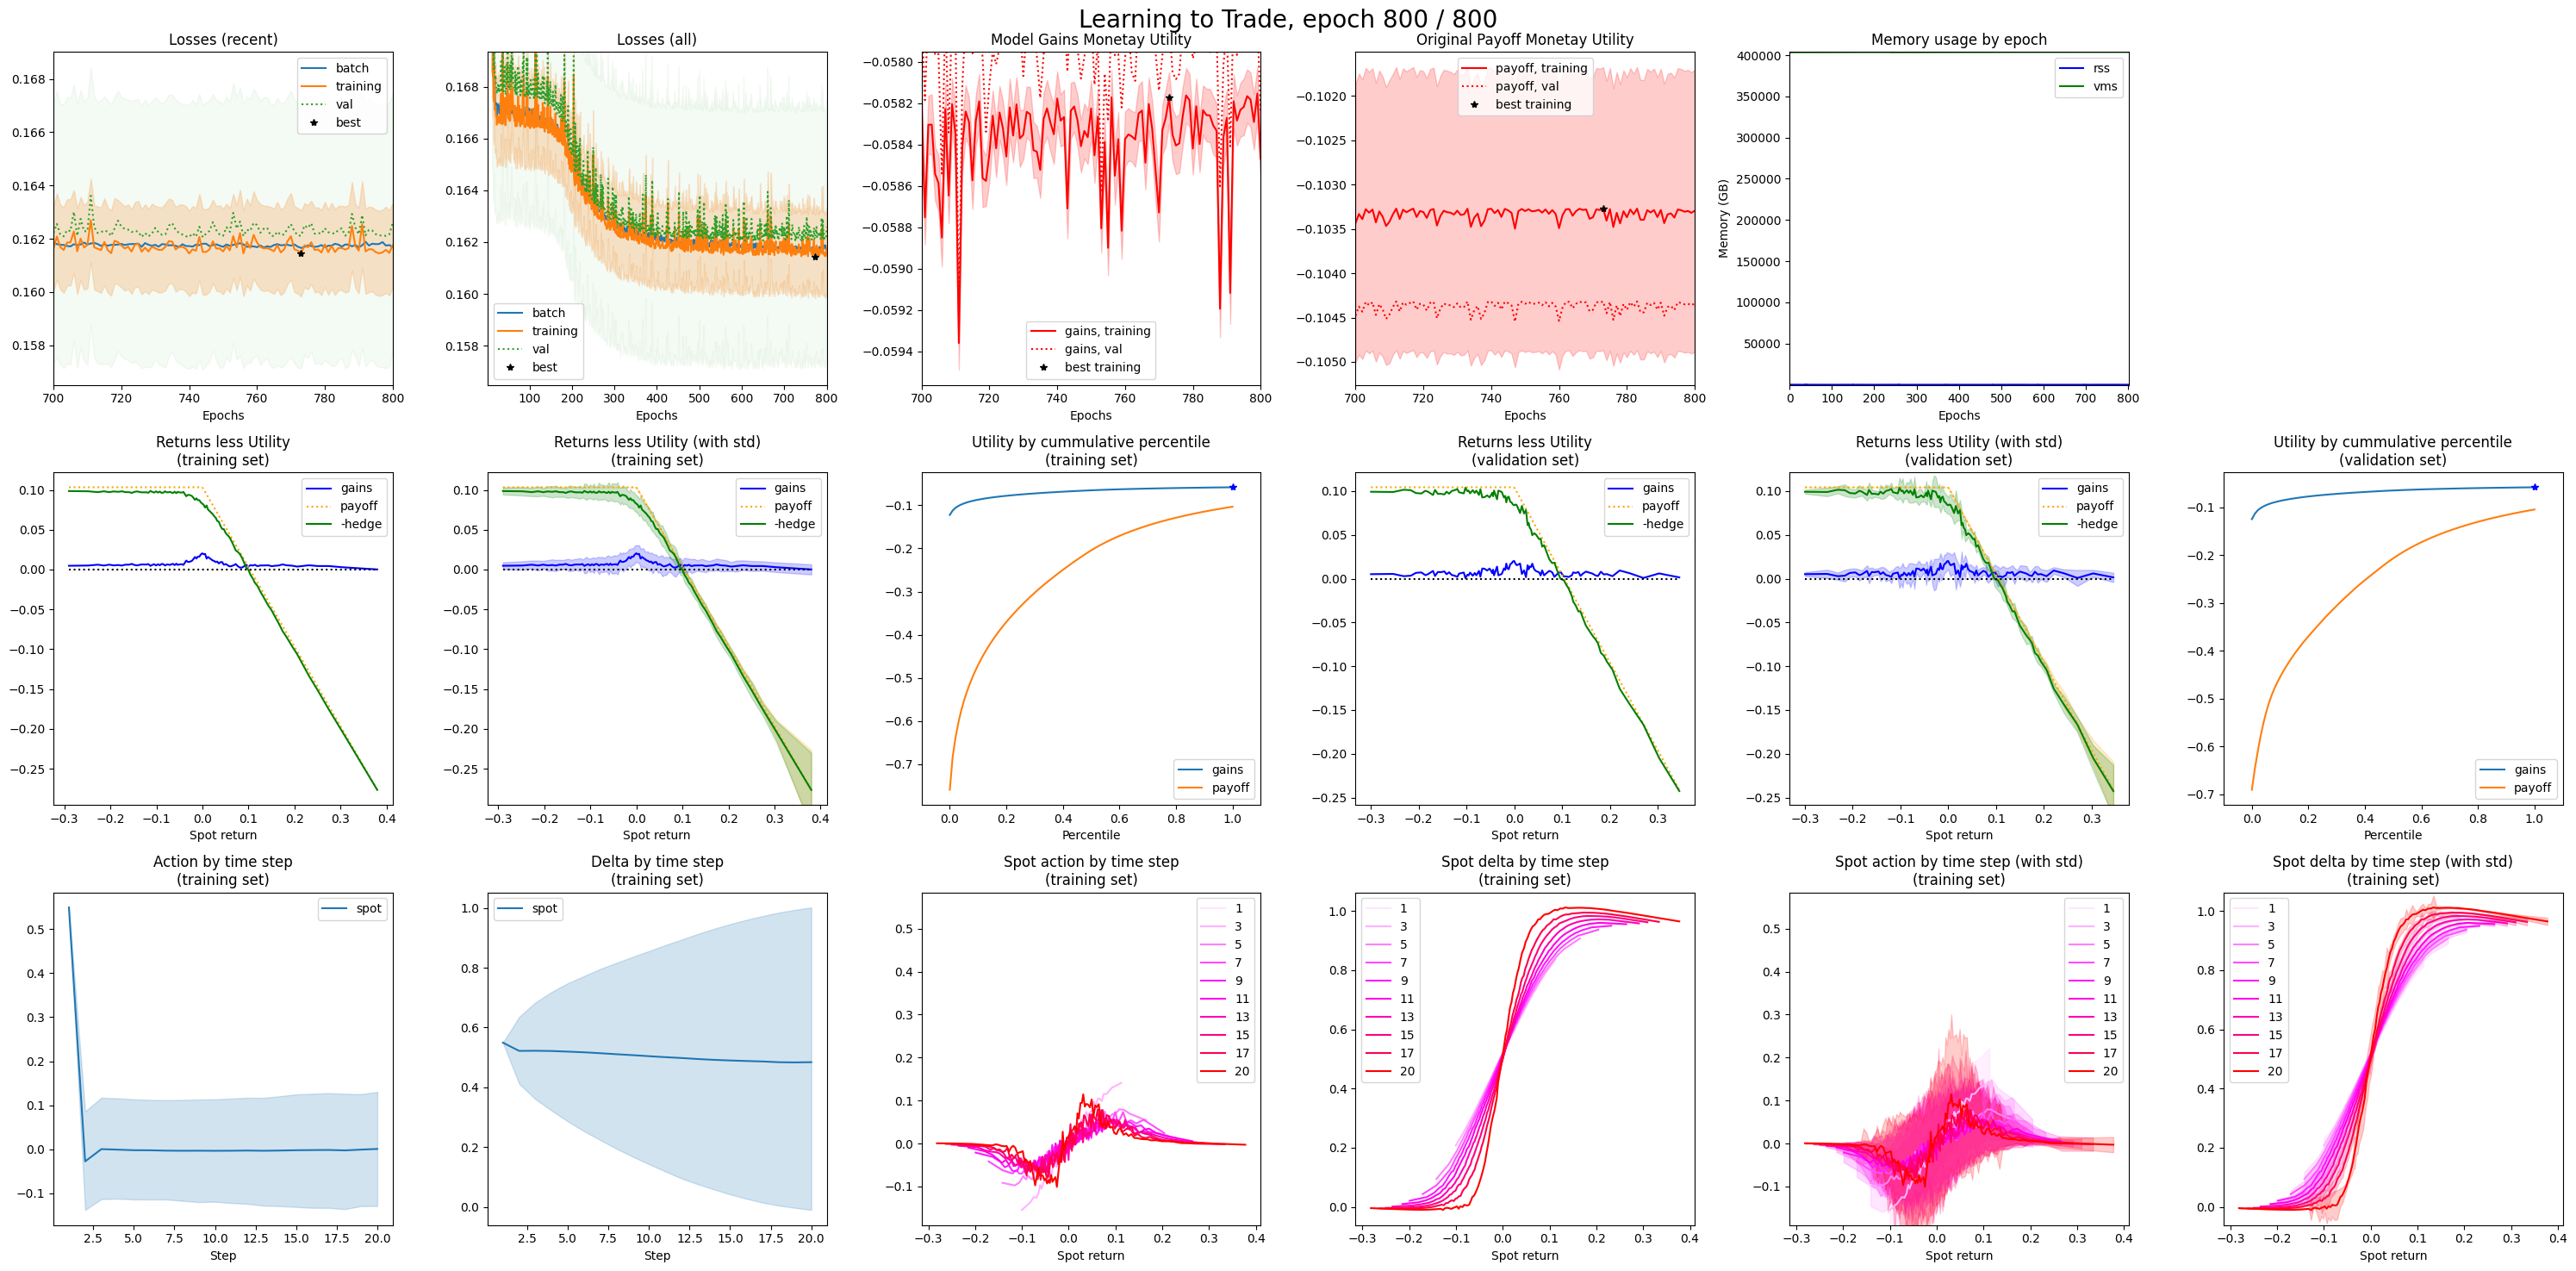

Training 800/800 epochs; 944 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.593179 (0.00907803), training 0.161763 (0.00157974), best 0.161444 (0.00907803), batch 0.161688, val 0.162583 (0.00488341); best epoch 773, last cached 800 | memory used: rss 149.812M, vms 403848M | time elapsed 46:06; time per epoch 3s; estimated time remaining 0s | current time: 2025-04-06 00:37:24                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 773
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck
 Time: 2025-04-06 00:37:25
Training terminated. Total time taken 5s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta.network['activation'] = relu # Network activation f

In [89]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 1.
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [39]:
# After training is done
result = gym(world.tf_data)

# result is a PrettyDict with:
print(result.keys())
import numpy as np

# Example: Compute mean utility and CVaR
utilities = result["utility"]
sample_weights = world.sample_weights

mean_utility = np.average(utilities, weights=sample_weights)

alpha = 0.01  # for 99% CVaR
sorted_util = np.sort(utilities)
cum_weights = np.cumsum(sample_weights[np.argsort(utilities)])
cvar_idx = cum_weights <= alpha * np.sum(sample_weights)
cvar = np.average(sorted_util[cvar_idx], weights=sample_weights[np.argsort(utilities)][cvar_idx])

# print(f"Mean Utility: {mean_utility:.4f}")
print(f"CVaR@99%: {cvar:.4f}")

print("Mean Utility (unhedged):", result["utility0"].numpy().mean())
print("Mean Utility (hedged):", result["utility"].numpy().mean())
print("payoff", result["payoff"].numpy().mean())
print("gains", result["gains"].numpy().mean())



odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
CVaR@99%: -0.1223
Mean Utility (unhedged): -0.10327124
Mean Utility (hedged): -0.05817323
payoff -0.051634893
gains -0.05079032


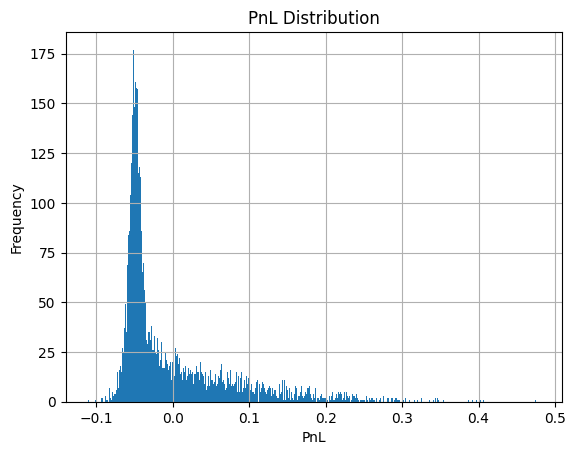

In [40]:
import matplotlib.pyplot as plt

plt.hist(result["pnl"], bins=1000)
plt.title("PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [41]:
actions = result["actions"].numpy()         # maybe shape (10000, 20, 1)
print(actions.shape)

(10000, 20, 1)


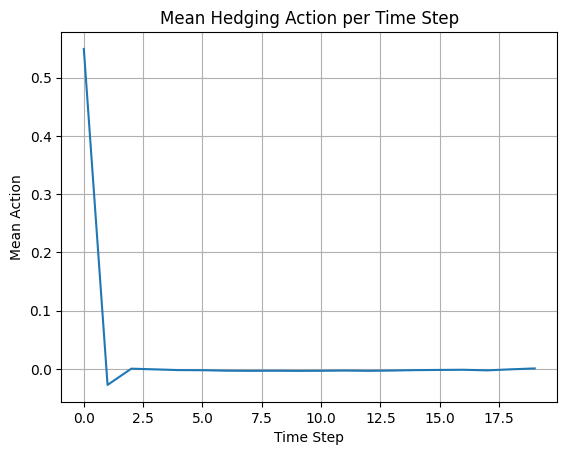

In [48]:
import matplotlib.pyplot as plt
import numpy as np

actions = result["actions"].numpy()  # shape (10000, 20, 1)

# Compute mean over all 10,000 scenarios → shape (20,)
mean_actions = actions.mean(axis=0).squeeze()

# Plot
plt.plot(mean_actions)
plt.title("Mean Hedging Action per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Mean Action")
plt.grid(True)
plt.show()

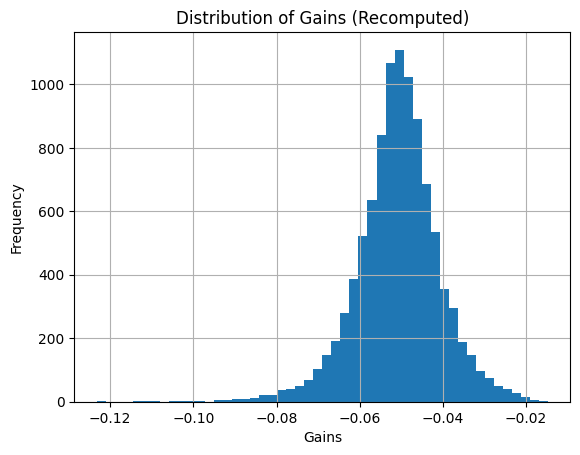

In [51]:
# If you instead want the step-wise PnL (cumulative), check if available
pnl = result["pnl"].numpy()        # shape (10000,)
cost = result["cost"].numpy()      # shape (10000,)
payoff = result["payoff"].numpy()  # shape (10000,)

gains = payoff + pnl - cost        # should match result["gains"]

plt.hist(gains, bins=50)
plt.title("Distribution of Gains (Recomputed)")
plt.xlabel("Gains")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [66]:
# For example, generate 5000 new test samples
test_world = world.clone(samples=500)

In [67]:
test_result = gym(test_world.tf_data)

In [68]:
test_result.keys()
# ['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions']

odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])

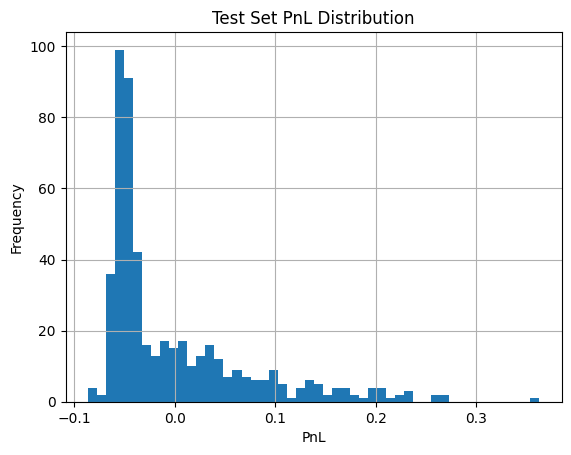

In [69]:
import matplotlib.pyplot as plt

plt.hist(test_result["pnl"].numpy(), bins=50)
plt.title("Test Set PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [70]:
import numpy as np

pnl = test_result["pnl"].numpy().flatten()
utility = test_result["utility"].numpy().flatten()
utility0 = test_result["utility0"].numpy().flatten()

print("Mean Utility (hedged):", np.mean(utility))
print("Mean Utility (unhedged):", np.mean(utility0))
print("CVaR@99% (hedged):", np.mean(np.sort(utility)[:int(0.01 * len(utility))]))

Mean Utility (hedged): -0.058723696
Mean Utility (unhedged): -0.09975568
CVaR@99% (hedged): -0.11869781


## PROTOTYPE

In [3]:
print("Deep Hedging AI says hello ... ", end='')

from cdxbasics.config import Config
import tensorflow as tf
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# ============================
# CONFIGURATION
# ============================
config = Config()

# World settings
config.world.samples = 10000
config.world.steps = 5
config.world.black_scholes = True

# Agent settings: use ProtoPNet agent
config.gym.agent("agent_type", "protopnet") 
config.gym.agent("features", ["price", "delta", "time_left"])
config.gym.agent("n_prototypes", 100)         
config.gym.agent("temperature", 0.01)

# Objective settings
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.

# Training config
config.trainer.train.optimizer.name = "adam"
config.trainer.train("run_eagerly", True)
config.trainer.train.epochs = 800
config.trainer.train.batch_size = None
config.trainer.caching.mode = "off"


# Visualization
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

# ============================
# RUN TRAINING
# ============================
display(Markdown("## Deep Hedging with ProtoPNet Agent"))

# Create world
world = SimpleWorld_Spot_ATM(config.world)
val_world = world.clone(samples=world.nSamples // 10)

# Create gym
gym = VanillaDeepHedgingGym(config.gym)

# Train (this builds the agent inside the gym)
train(gym=gym, world=world, val_world=val_world, config=config.trainer)

agent = gym.agent 

actions_per_prototype = agent.proto_layer.output_weights.numpy()
for i, w in enumerate(actions_per_prototype):
    print(f"Prototype #{i}: Action(s) = {w}")

# Evaluate
r = gym(world.tf_data)

# similarities = agent.similarities
# print("Similarities shape:", similarities.shape)
# print("Most active prototype per sample (first 10):", tf.argmax(similarities, axis=1).numpy()[:10])

print("Keys of the dictionary returned by the gym:", r.keys())

# Report
print("=========================================")
print("Config usage report")
print("=========================================")
print(config.usage_report())
config.done()

Deep Hedging AI says hello ... 

## Deep Hedging with ProtoPNet Agent


[Step 0 ] Similarities (sample 0): [0.00704644853 0.00727421185 0.0123928133 ... 0.0124035152 0.0130752716 0.0142216273]
Top 3 prototypes (sample 0): [89 16 77]
Their similarities: [0.0154694058 0.015175527 0.0150922807]
Their similarities after normalization: [0.338223606 0.331798226 0.329978138]
 - Prototype # 89 : action = [-0.062499702]
 - Prototype # 16 : action = [0.0954814553]
 - Prototype # 77 : action = [0.0900087357]
Final Actions = [-0.0178728364]

[Step 1 ] Similarities (sample 0): [0.00788442418 0.00870000944 0.0109882439 ... 0.0129293557 0.0133453207 0.0157541241]
Top 3 prototypes (sample 0): [87 77 99]
Their similarities: [0.0165649597 0.0162782185 0.0157541241]
Their similarities after normalization: [0.340861678 0.334961325 0.324176908]
 - Prototype # 87 : action = [0.026550889]
 - Prototype # 77 : action = [0.0900087357]
 - Prototype # 99 : action = [-0.221594736]
Final Actions = [-0.0195839852]

[Step 2 ] Similarities (sample 0): [0.00864831917 0.0102195246 0.009640

AssertionError: Do not call me before the first epoch

In [28]:
print(gym.agent.features)             # Features actually used
print(gym.agent.available_features)   # All features available from the world

ListWrapper(['delta', 'price', 'time_left'])
['action', 'cost', 'delta', 'ivol', 'lbnd_a', 'pnl', 'price', 'spot', 'sqrt_time_left', 'time_left', 'ubnd_a']


#### Comparison to Black & Scholes

See also notebooks/blackscholes for other notebooks. Note that we use medium risk aversion, hence the hedge is not expected to match the risk-neutral hedge. See the sub directory <tt>blackscholes</tt> for experiments approximating the black & scholes solution

Deep Hedging AI says hello ... 

## Deep Hedging in a Black \& Scholes World

Initializing training at 2025-03-29 14:20:23: gym with 944 trainable weights compiled. Took 0s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/6

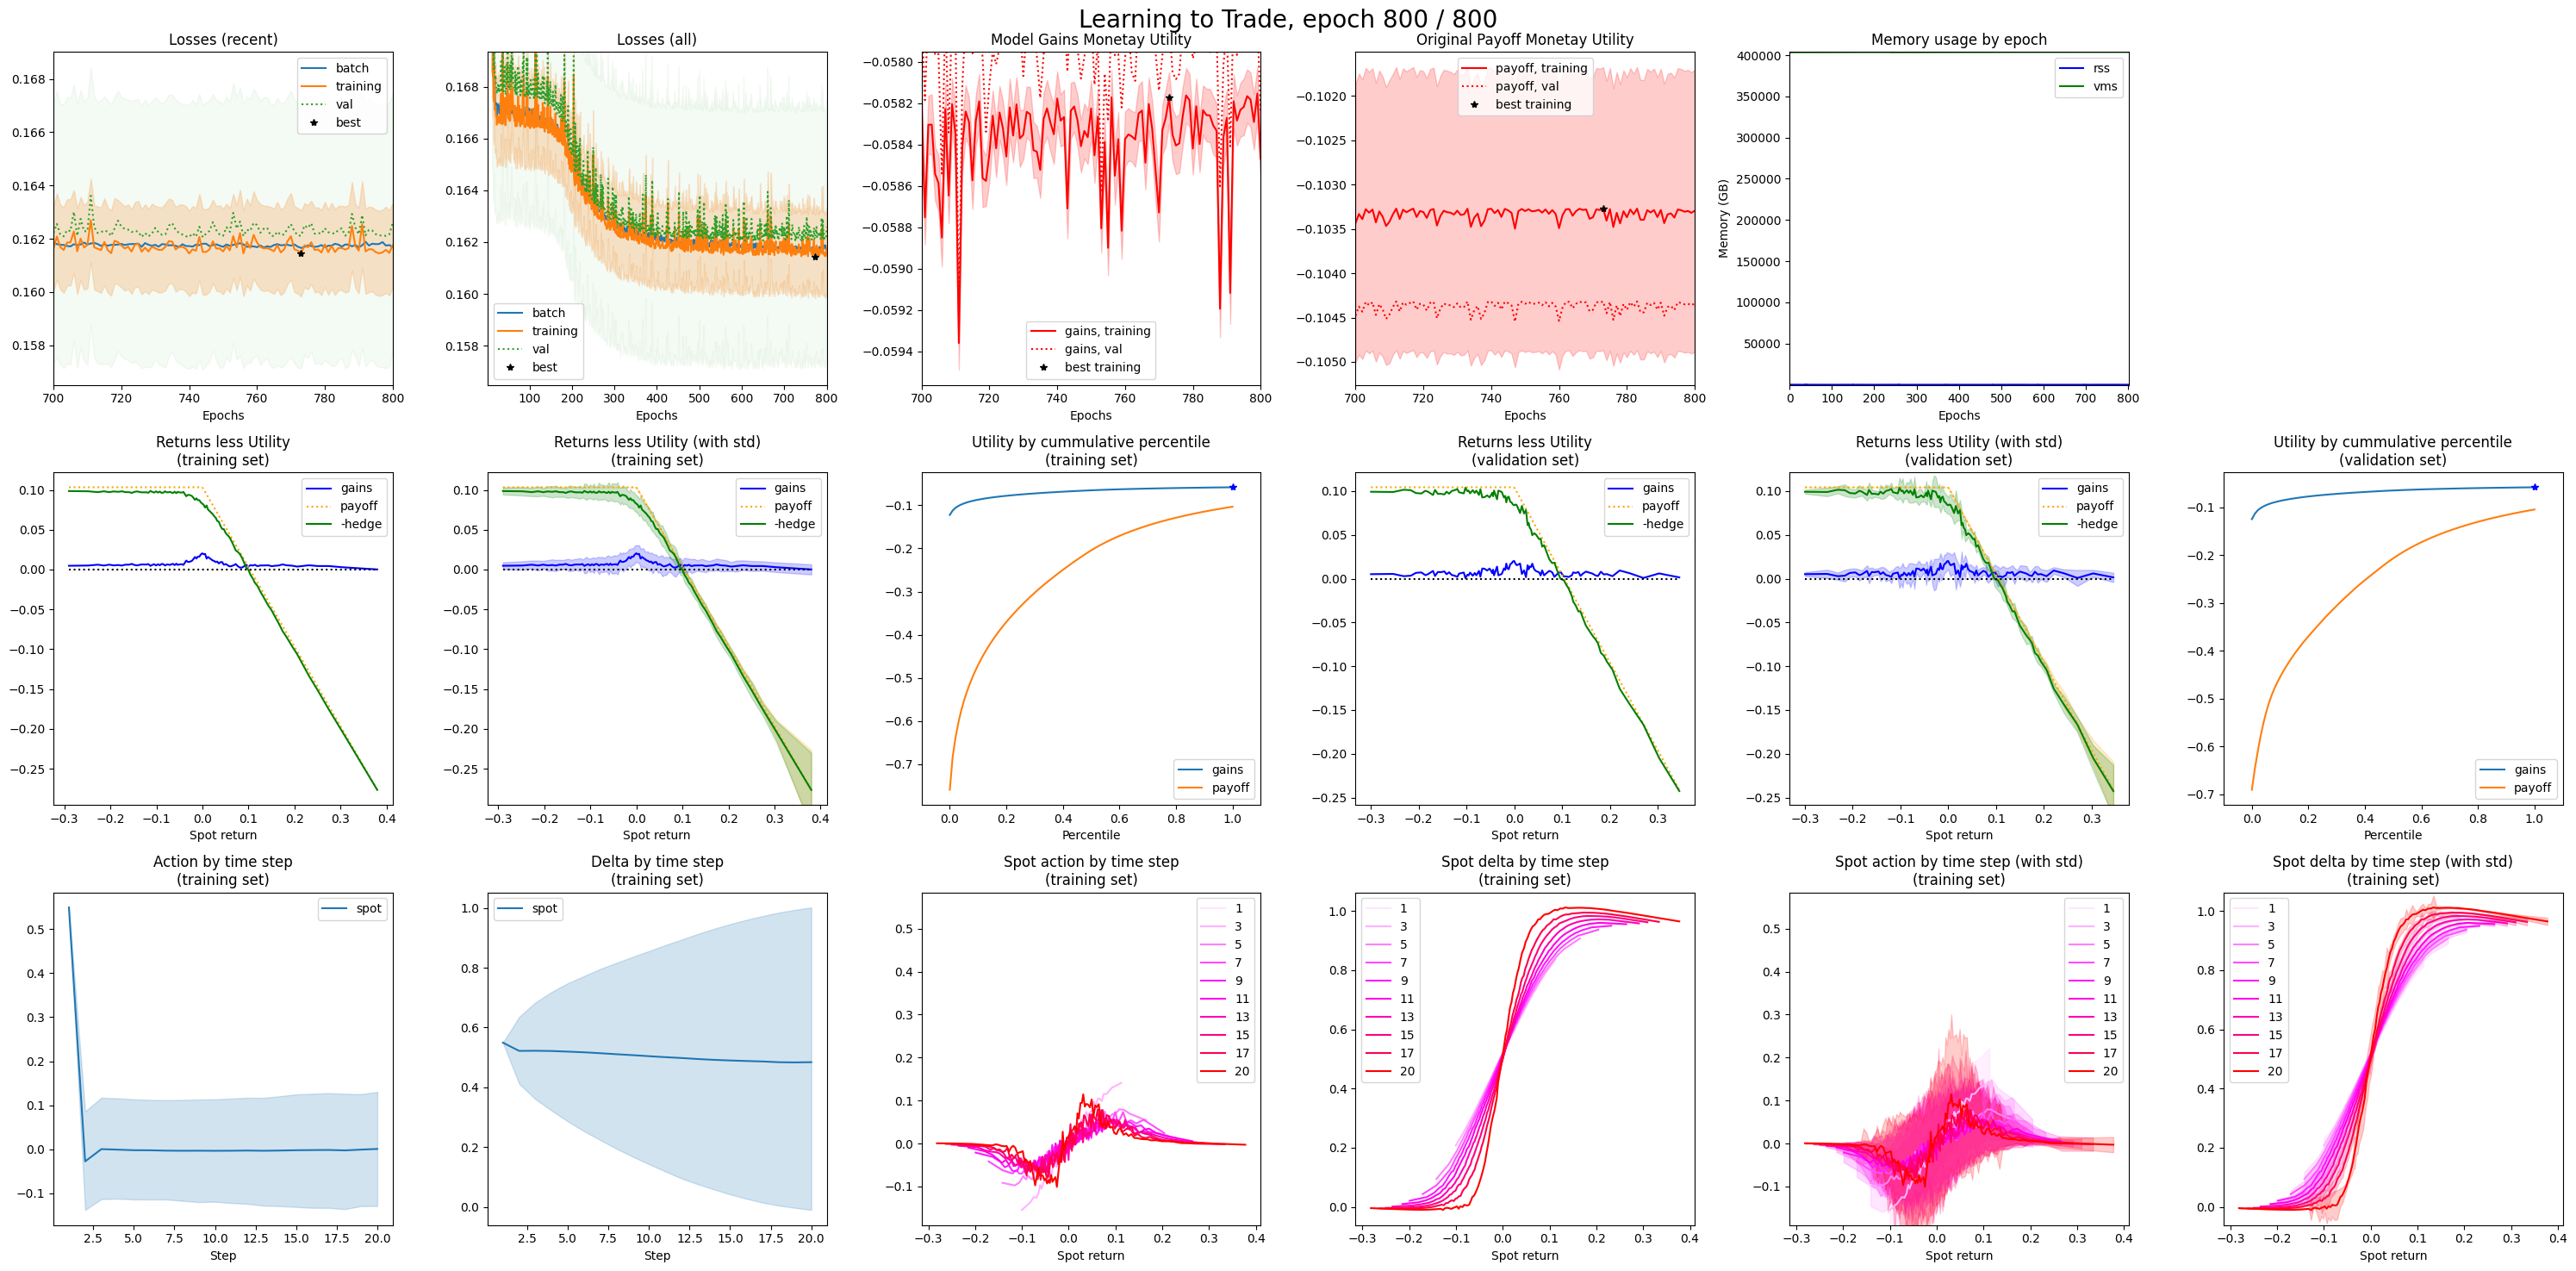

Training 800/800 epochs; 944 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.593179 (0.00907803), training 0.161763 (0.00157974), best 0.161444 (0.00907803), batch 0.161688, val 0.162583 (0.00488341); best epoch 773, last cached 800 | memory used: rss 149.812M, vms 403848M | time elapsed 46:06; time per epoch 3s; estimated time remaining 0s | current time: 2025-03-29 14:20:26                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 773
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck
 Time: 2025-03-29 14:20:27
Training terminated. Total time taken 3s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta.network['activation'] = relu # Network activation f

In [24]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 1.
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

Running strategies ...done
Running tensorflow to compute utility of BS strategy ...done; result -0.0516349
Rendering now. Stand by.


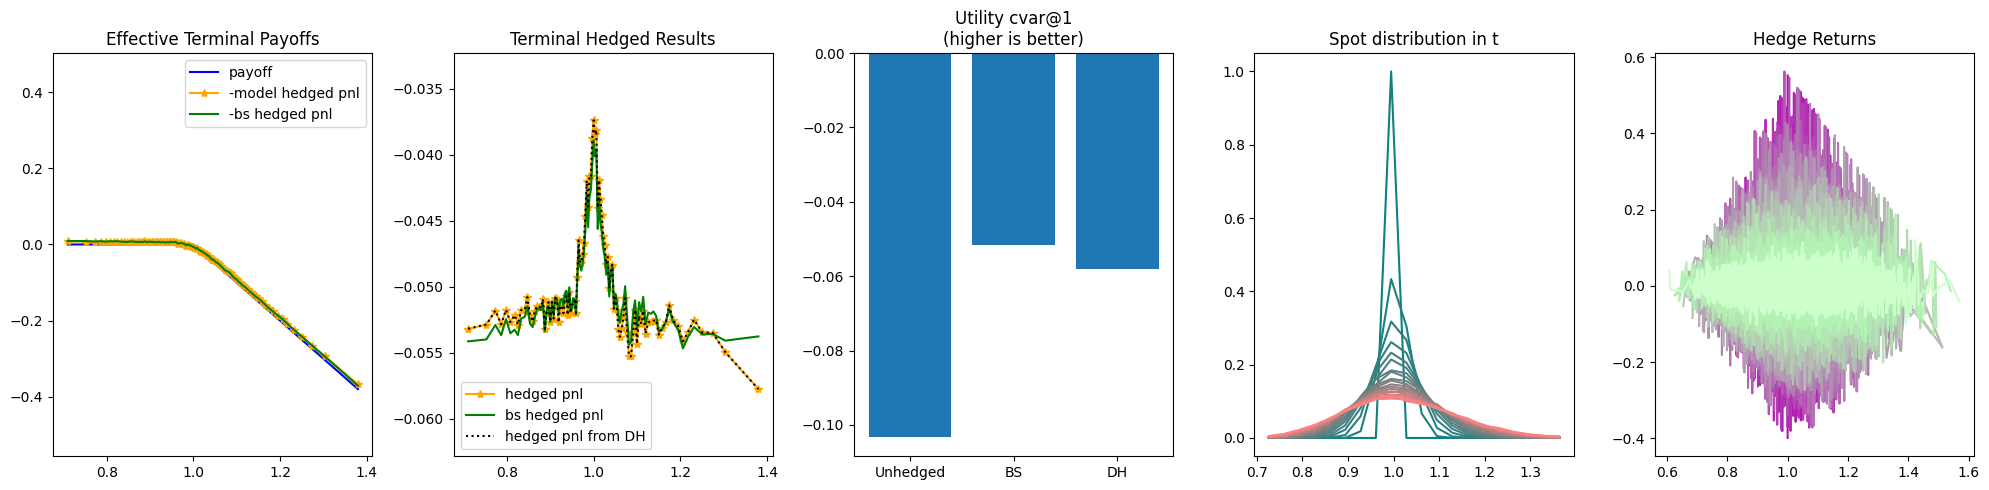

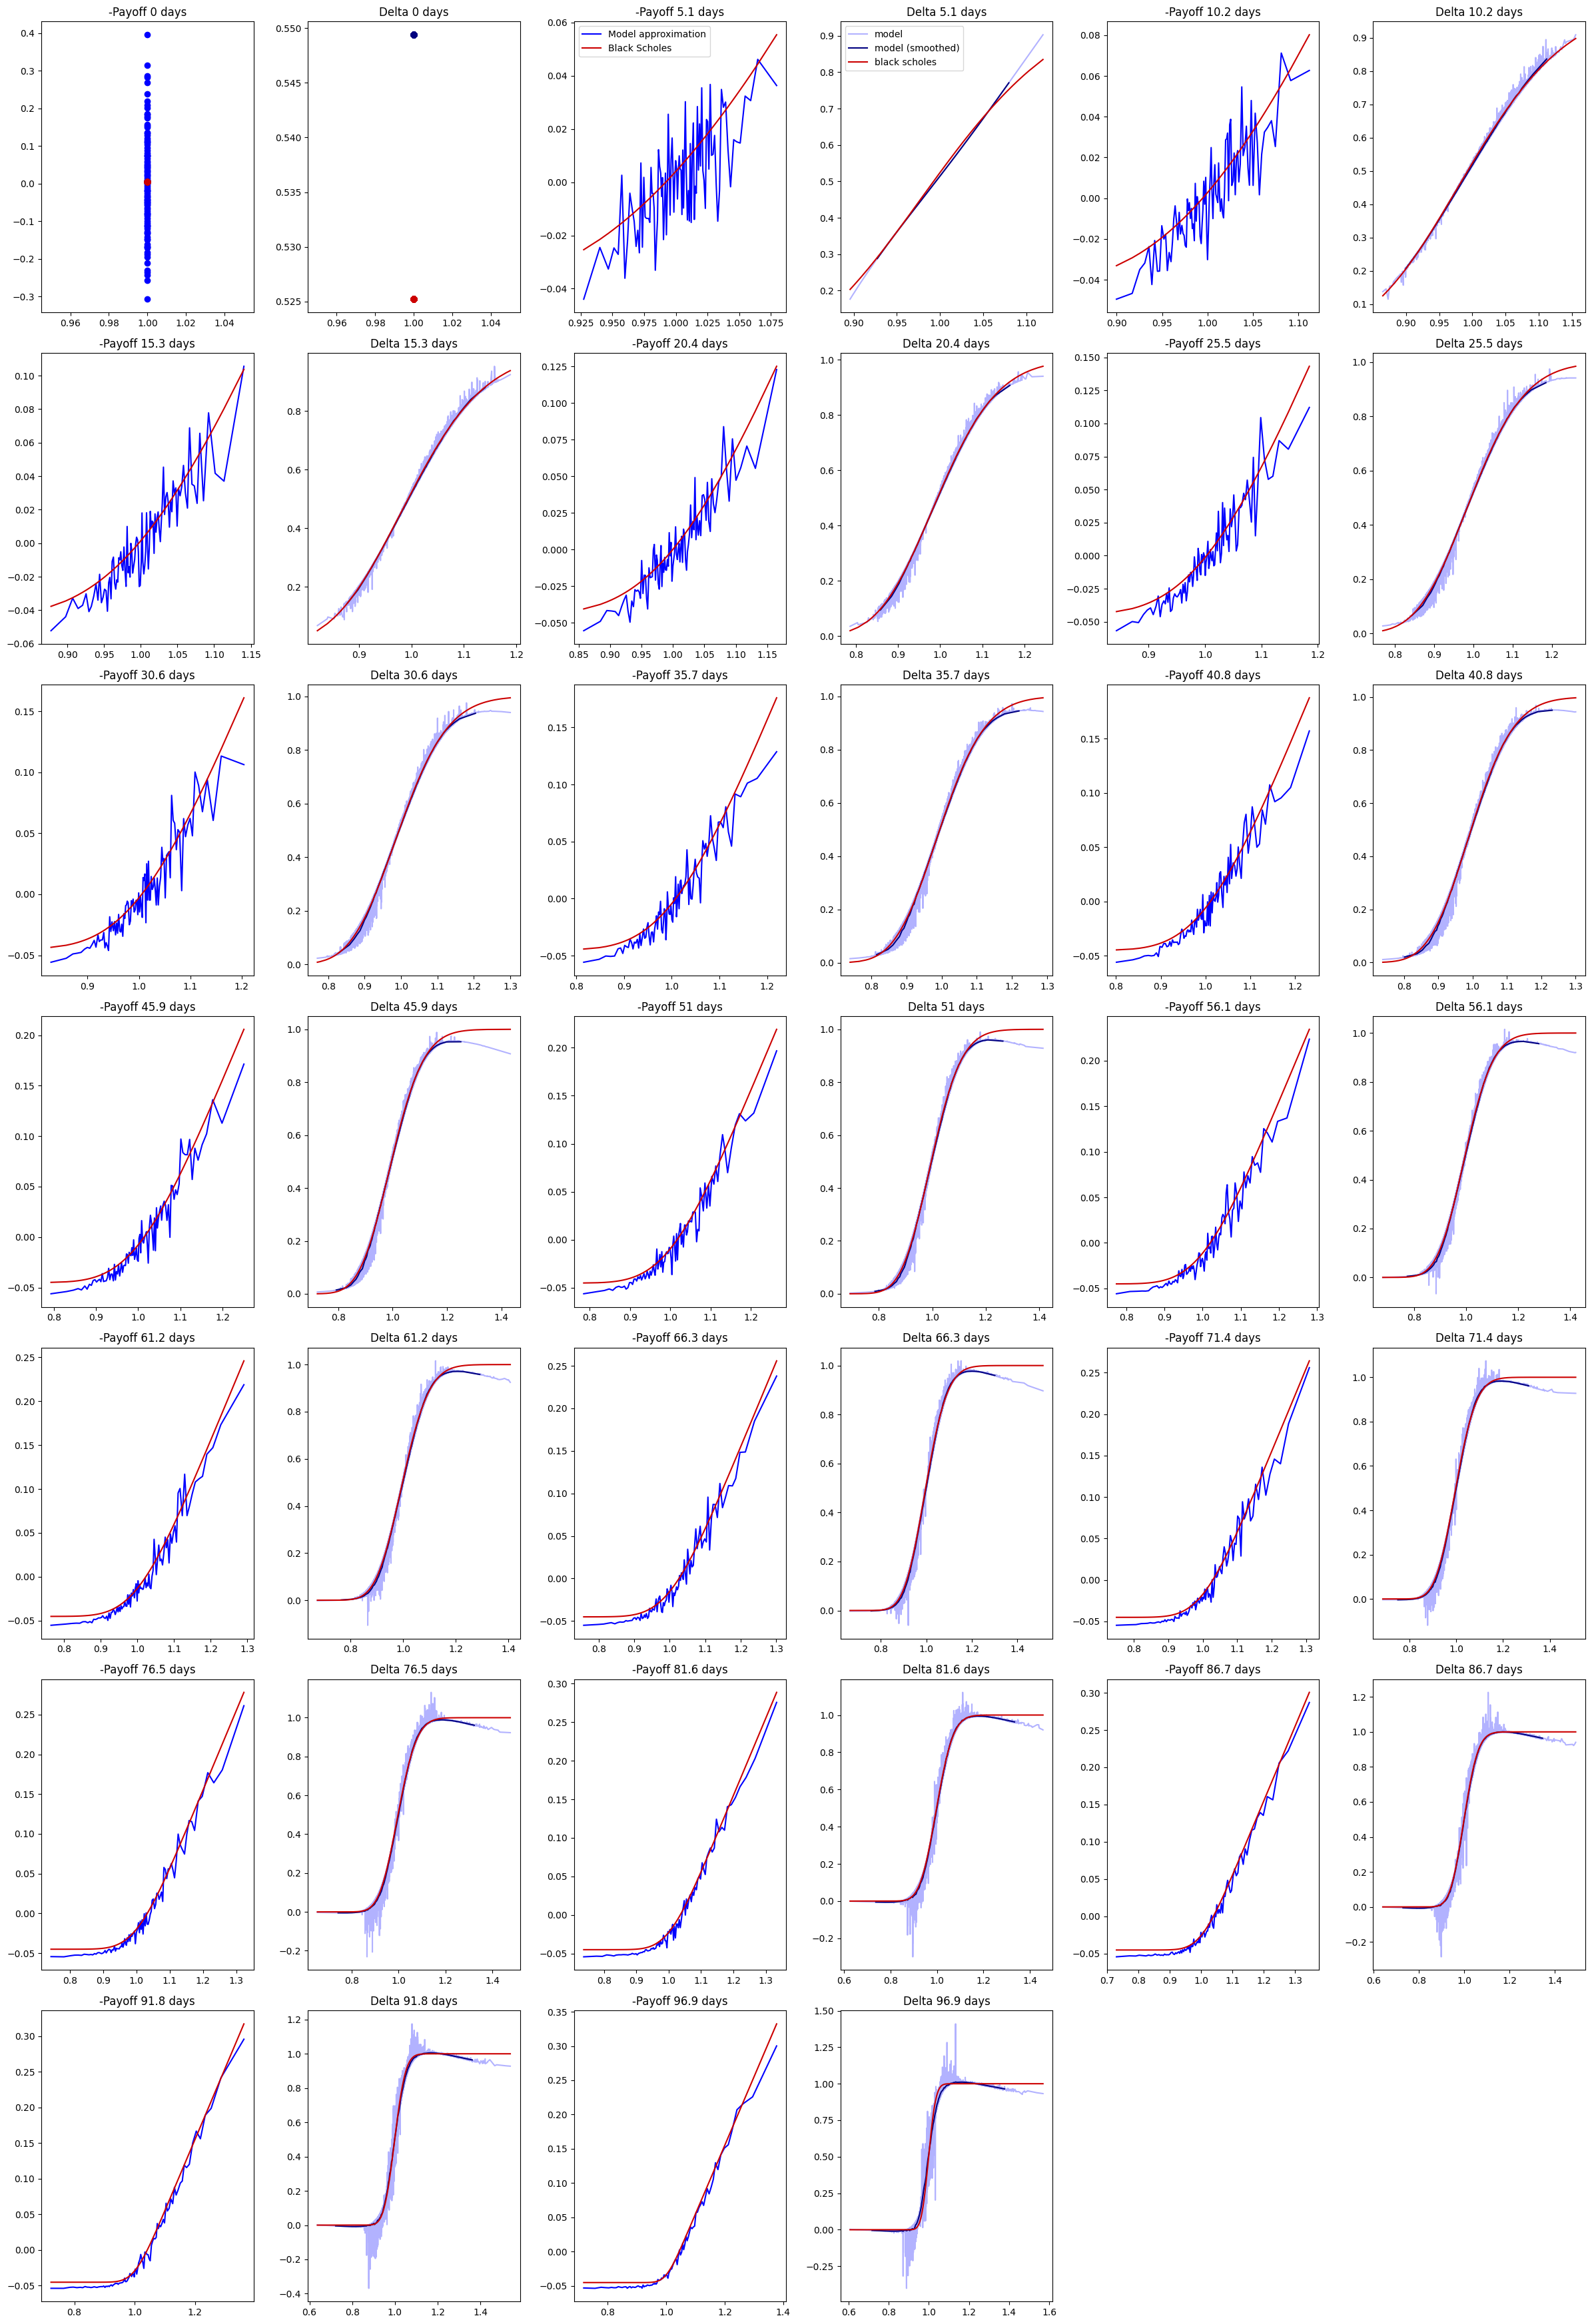

In [25]:
import deephedging.plot_bs_hedge as plot_bs_hedge
plot_bs_hedge.plot_blackscholes( world, gym, config )

Deep Hedging AI says hello ... 

## Deep Hedging in a Black \& Scholes World

Initializing training at 2025-03-26 12:55:14: gym with 944 trainable weights compiled. Took 0s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/6

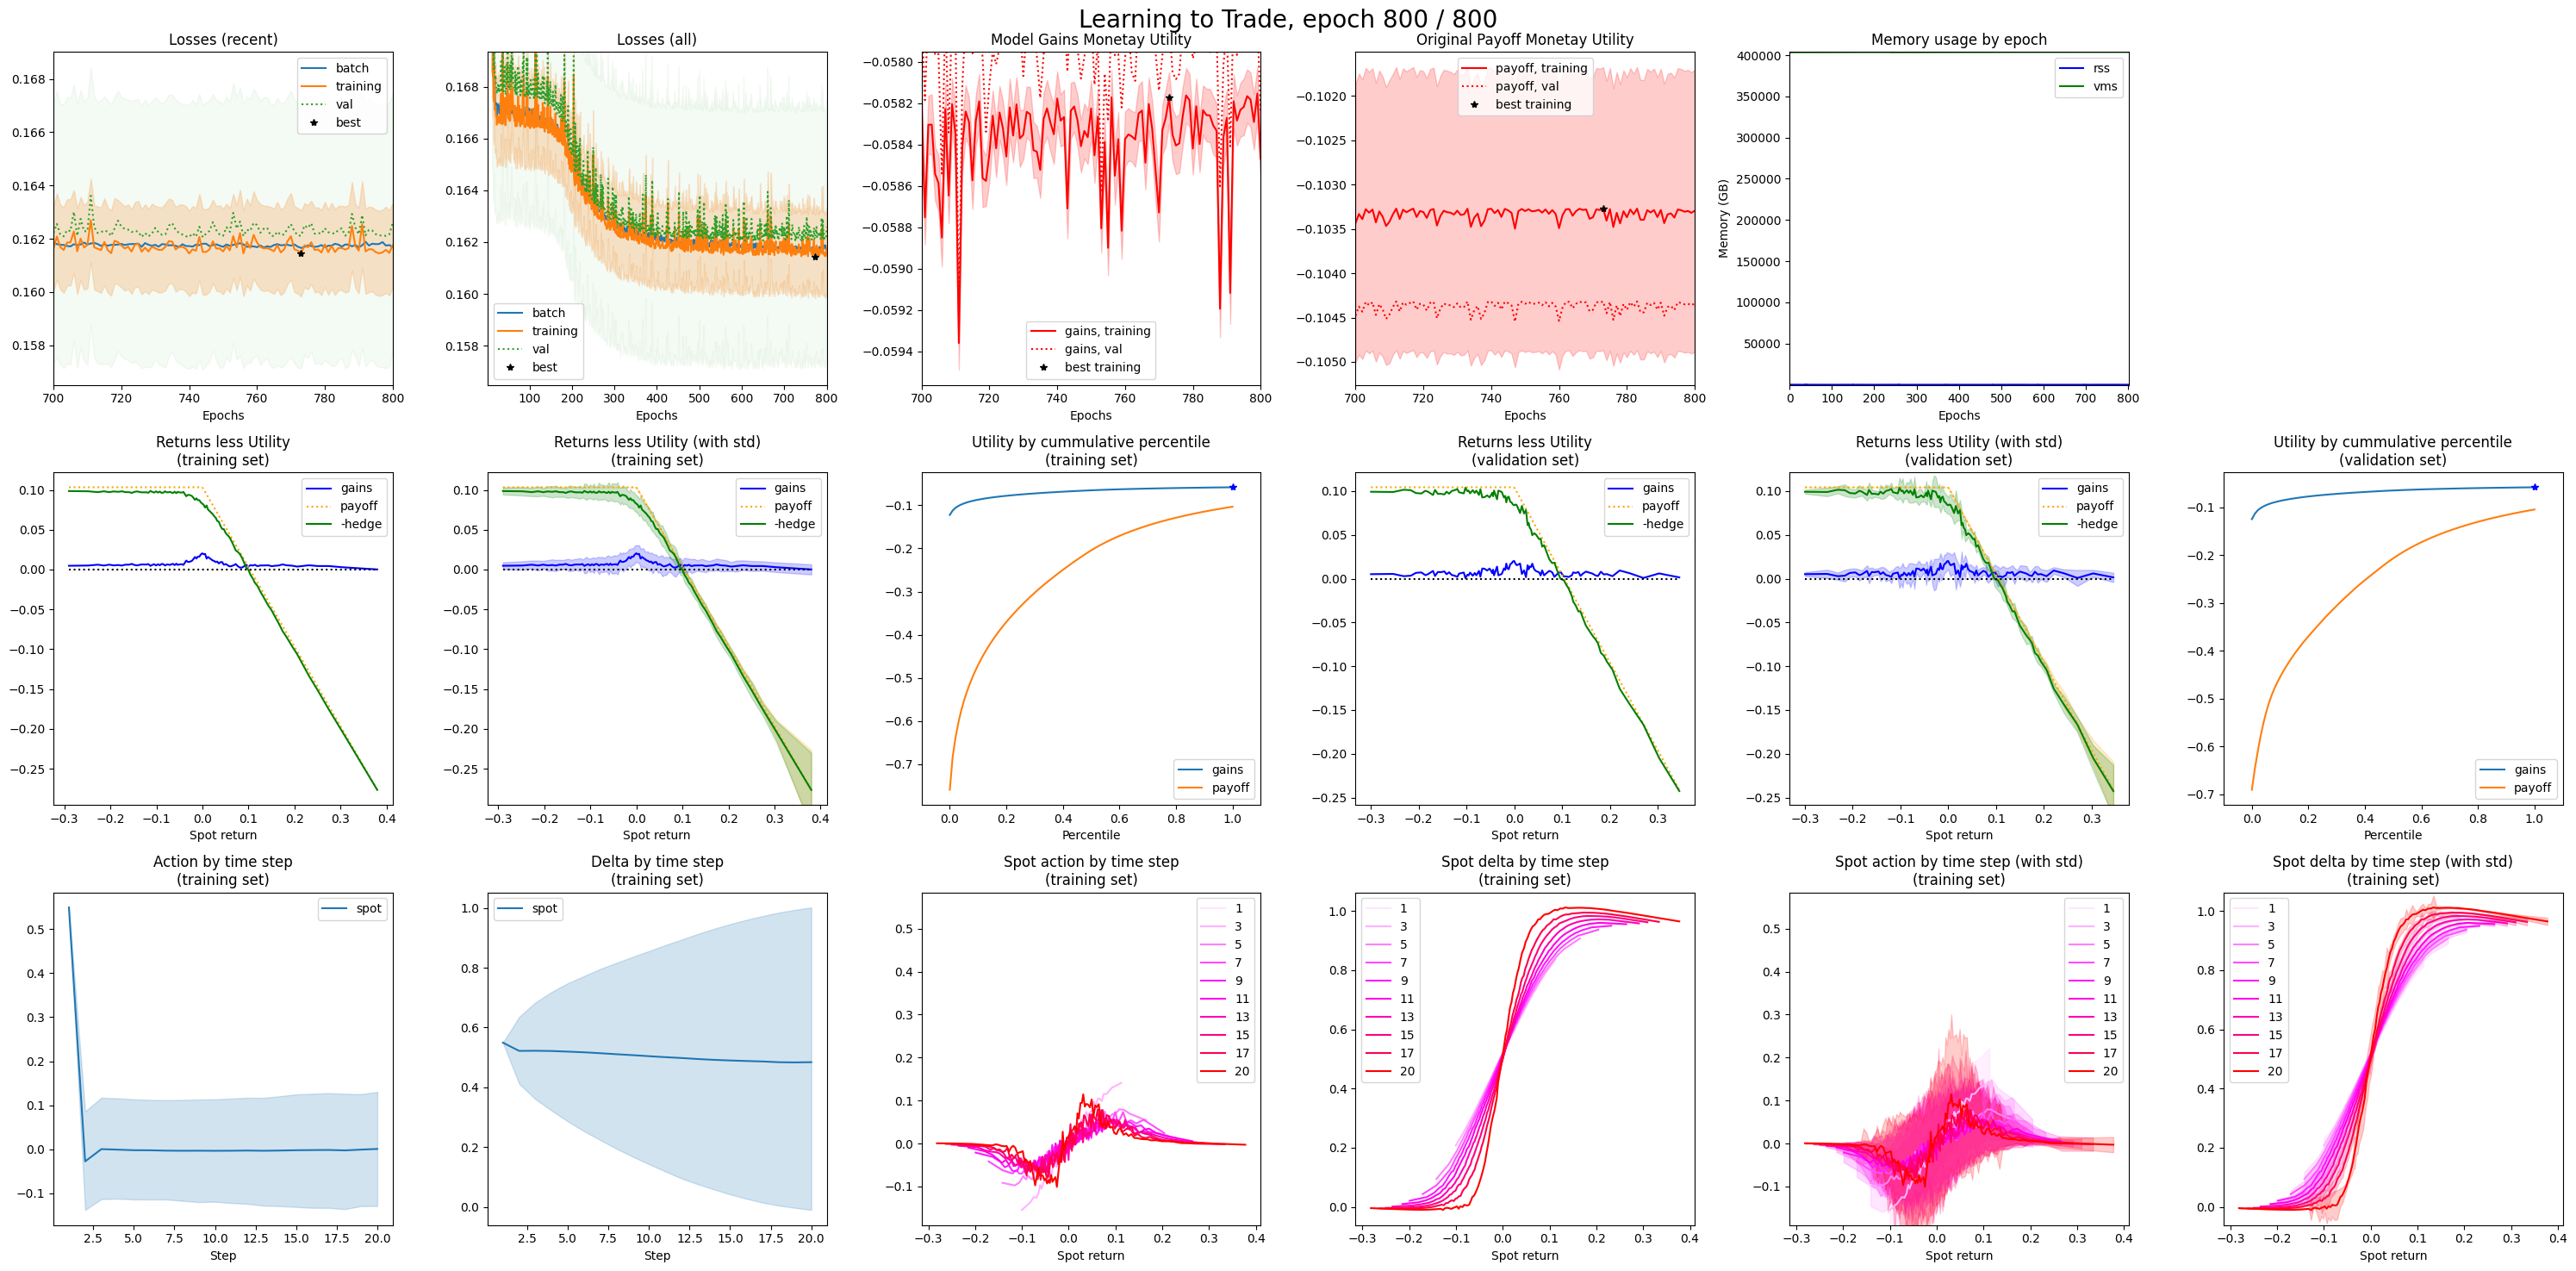

Training 800/800 epochs; 944 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.593179 (0.00907803), training 0.161763 (0.00157974), best 0.161444 (0.00907803), batch 0.161688, val 0.162583 (0.00488341); best epoch 773, last cached 800 | memory used: rss 149.812M, vms 403848M | time elapsed 46:06; time per epoch 3s; estimated time remaining 0s | current time: 2025-03-26 12:55:17                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 773
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck
 Time: 2025-03-26 12:55:18
Training terminated. Total time taken 3s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta.network['activation'] = relu # Network activation f

In [6]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 1.
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

## Stochastic Vol
### Trading with two assets

Deep Hedging AI says hello  ... 

## Deep Hedging in a simple Stochastic Volatility World

Initializing training at 2025-04-02 11:04:15: gym with 1006 trainable weights compiled. Took 3s
Agent is using 1004 weights: 1002 for the main agent per step, 2 for initial delta.
 Features available per time step:     action, call_delta, call_price, call_vega, cost, cost_v, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/0289de81ceae5149b374906e1eef963ea942d6263b8cf383.pck'
Cache successfully loaded. Current e

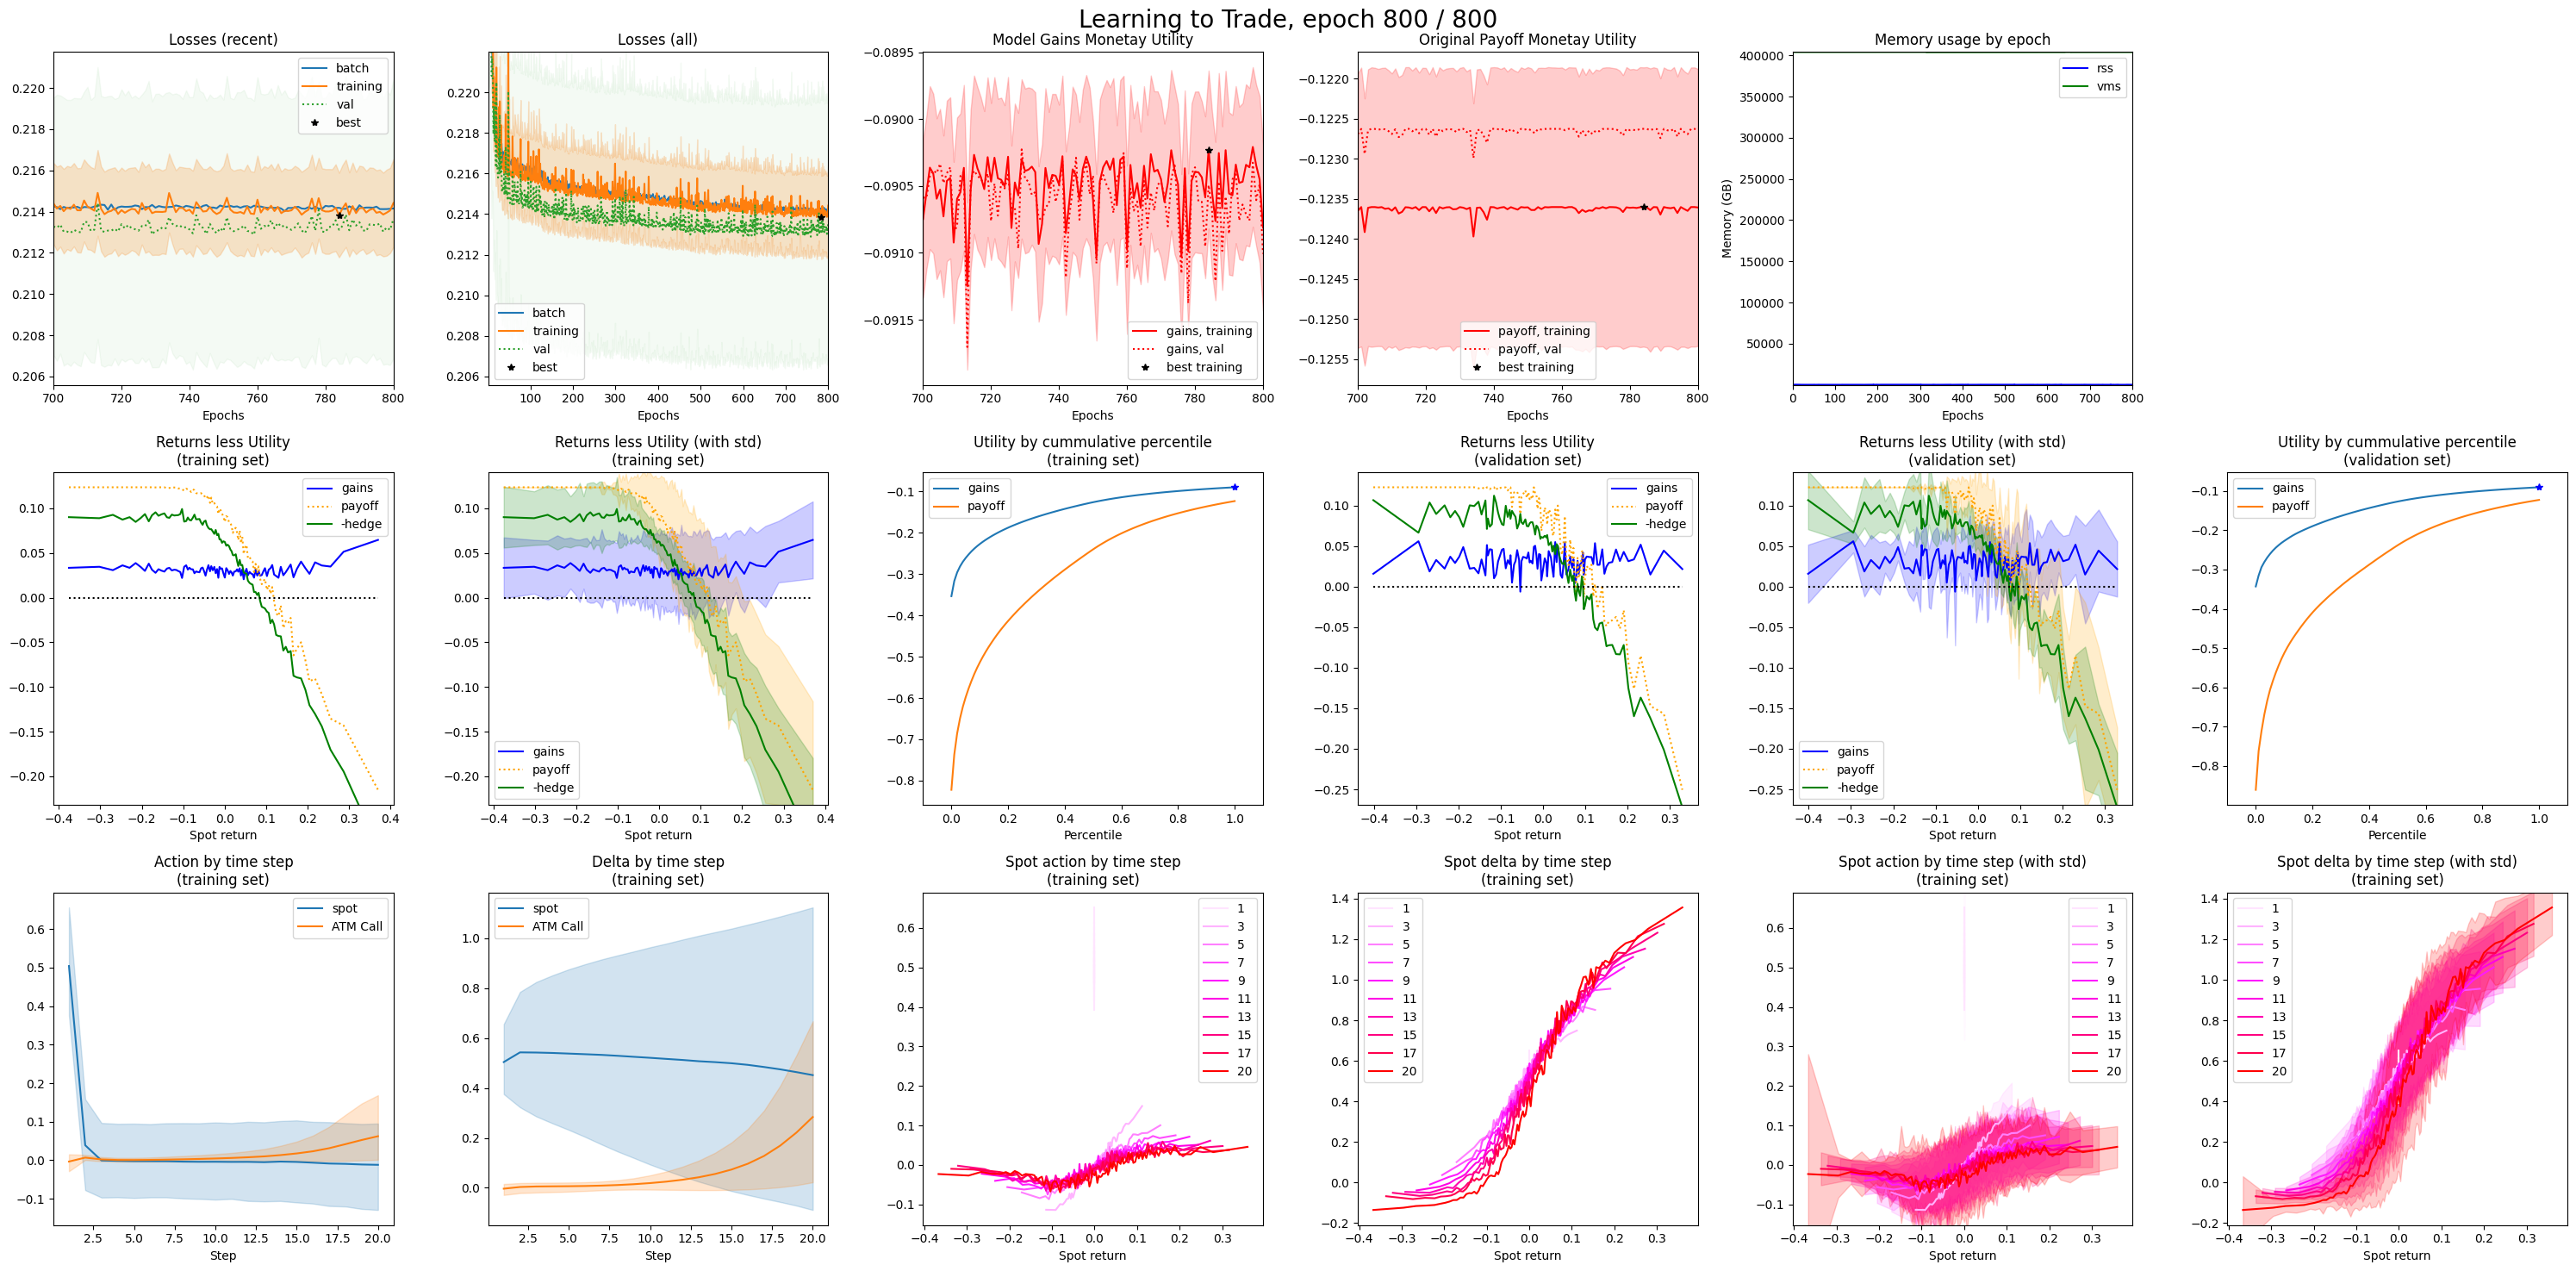

Training 800/800 epochs; 1006 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.7133 (0.0101046), training 0.21442 (0.00212935), best 0.213832 (0.0101046), batch 0.214154, val 0.213644 (0.00676745); best epoch 784, last cached 800 | memory used: rss 172.703M, vms 403947M | time elapsed 2:37:48; time per epoch 11s; estimated time remaining 0s | current time: 2025-04-02 11:04:19                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 784
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/0289de81ceae5149b374906e1eef963ea942d6263b8cf383.pck
 Time: 2025-04-02 11:04:22
Training terminated. Total time taken 7s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta.network['activation'] = relu # Network activation fu

In [71]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [ ]:
# After training is done
result = gym(world.tf_data)

# result is a PrettyDict with:
print(result.keys())
import numpy as np

# Example: Compute mean utility and CVaR
utilities = result["utility"]
sample_weights = world.sample_weights

mean_utility = np.average(utilities, weights=sample_weights)

alpha = 0.10  # for 99% CVaR
sorted_util = np.sort(utilities)
cum_weights = np.cumsum(sample_weights[np.argsort(utilities)])
cvar_idx = cum_weights <= alpha * np.sum(sample_weights)
cvar = np.average(sorted_util[cvar_idx], weights=sample_weights[np.argsort(utilities)][cvar_idx])

# print(f"Mean Utility: {mean_utility:.4f}")
print(f"CVaR@99%: {cvar:.4f}")

print("Mean Utility (unhedged):", result["utility0"].numpy().mean())
print("Mean Utility (hedged):", result["utility"].numpy().mean())
print("payoff", result["payoff"].numpy().mean())


odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
CVaR@99%: -0.1271
Mean Utility (unhedged): -0.123603806
Mean Utility (hedged): -0.090227894
payoff -0.06182776


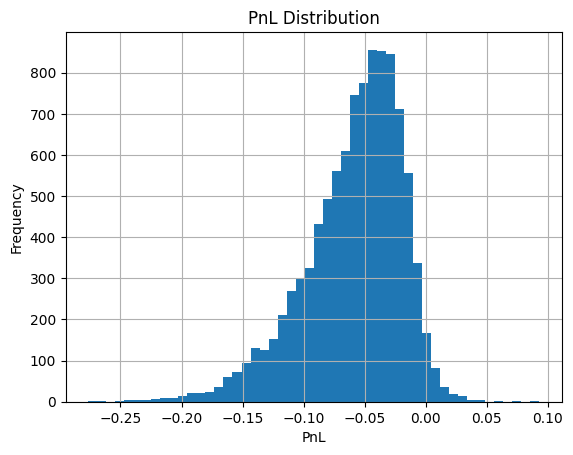

In [27]:
import matplotlib.pyplot as plt

plt.hist(result["gains"], bins=50)
plt.title("PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [72]:
# For example, generate 5000 new test samples
test_world = world.clone(samples=5000)

In [73]:
test_result = gym(test_world.tf_data)

In [74]:
test_result.keys()
# ['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions']

odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])

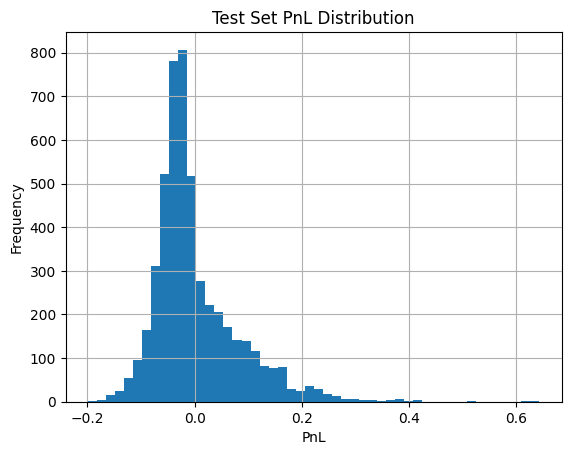

In [75]:
import matplotlib.pyplot as plt

plt.hist(test_result["pnl"].numpy(), bins=50)
plt.title("Test Set PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [88]:
# mean : 
test_result["cost"].numpy().mean()

0.001104966

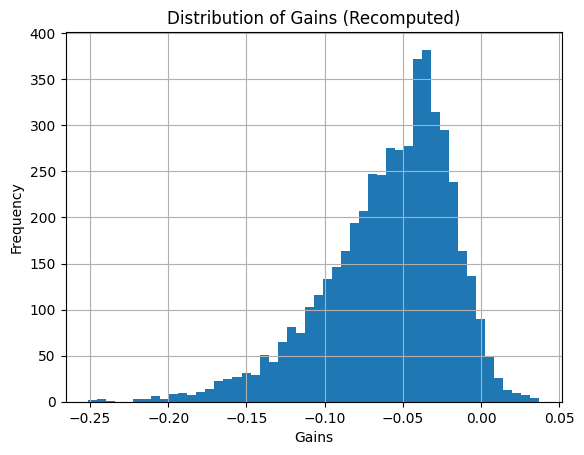

In [84]:
test_result["actions"].shape


# If you instead want the step-wise PnL (cumulative), check if available
pnl = test_result["pnl"].numpy()        # shape (10000,)
cost = test_result["cost"].numpy()      # shape (10000,)
payoff = test_result["payoff"].numpy()  # shape (10000,)
gains = payoff + pnl - cost        # should match result["gains"]
plt.hist(gains, bins=50)
plt.title("Distribution of Gains (Recomputed)")
plt.xlabel("Gains")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [2]:
import numpy as np

pnl = test_result["pnl"].numpy().flatten()
utility = test_result["utility"].numpy().flatten()
utility0 = test_result["utility0"].numpy().flatten()

print("Mean Utility (hedged):", np.mean(utility))
print("Mean Utility (unhedged):", np.mean(utility0))
print("CVaR@99% (hedged):", np.mean(np.sort(utility)[:int(0.01 * len(utility))]))

NameError: name 'test_result' is not defined